# Image classification using Resnet50 from Scratch

In [1]:
import os
import xml.etree.ElementTree as ET
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

### Load Dataset

In [2]:
CLASS_LABEL_MAP = {'crosswalk': 0, 'speedlimit': 1, 'stop': 2, 'trafficlight': 3}

In [3]:
def load_dataset():
    # directory paths
    img_dir = "Dataset/images"
    ann_dir = "Dataset/annotations"

    images = []
    labels = []

    for img_name in os.listdir(img_dir):
        # Load image
        img_path = os.path.join(img_dir, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = image / 255.0 # Normalize to be in the range 0-1

        # Load corresponding annotation
        ann_path = os.path.join(ann_dir, img_name.replace('.png', '.xml'))
        tree = ET.parse(ann_path)
        root = tree.getroot()
        label = root.find("object").find("name").text  # Extract object label

        images.append(image)
        labels.append(CLASS_LABEL_MAP[label]) # Convert string label to numeric

    return np.array(images), np.array(labels)

In [4]:
X, y = load_dataset()

In [5]:
X.shape, y.shape

((877, 224, 224, 3), (877,))

### Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.shape, X_test.shape

((701, 224, 224, 3), (176, 224, 224, 3))

### Model Definition

<img src="./Resnet50 Architecture.png"> 

<a href="https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758/">Architecture reference blog: Towards-Data-Science ResNet50</a>

In [10]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization  
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam

<img src="./ResNet50 Identity Block.png"> 

In [11]:
# Identity block definition

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure   

    Parameters
    ----------
    X : tensor
        input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f : integer
        specifying the shape of the middle CONV's window for the main path
    filters : list
        python list of integers, defining the number of filters in the CONV layers of the main path
    stage : integer
        used to name the layers, depending on their position in the network
    block : str
        used to name the layers, depending on their position in the network

    Returns
    -------
    X : tensor
        output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. we'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', 
               name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', 
               name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', 
               name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

<img src="./ResNet50 Convolutional Block.png"> 

In [13]:
# Identity block definition

def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure   

    Parameters
    ----------
    X : tensor
        input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f : integer
        specifying the shape of the middle CONV's window for the main path
    filters : list
        python list of integers, defining the number of filters in the CONV layers of the main path
    stage : integer
        used to name the layers, depending on their position in the network
    block : str
        used to name the layers, depending on their position in the network
    s : integer, optional
        Integer, specifying the stride to be used. The default is 2.

    Returns
    -------
    X : tensor
        output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [17]:
# Function for implementing ResNet50

def CustomResNet50(input_shape, outputClasses):
    """
    Parameters
    ----------
    input_shape : tuple, optional
        shape of the input image. 
    outputClasses : integer, optional
        number of classes. 

    Returns
    -------
    model : object
        a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3 
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL 
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(outputClasses, activation='softmax', name='fc' + str(outputClasses), 
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [18]:
resnet_model = CustomResNet50(input_shape=(224, 224, 3), outputClasses=6)

In [19]:
resnet_model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1 (Conv2D)                │ (None, 112, 112, 64)      │           9,472 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_conv1 (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 112, 112, 64)      │               0 │ bn_conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 55, 55, 64)        │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2a (Conv2D)       │ (None, 55, 55, 64)        │           4,160 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2a                 │ (None, 55, 55, 64)        │             256 │ res2a_branch2a[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 55, 55, 64)        │               0 │ bn2a_branch2a[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2b (Conv2D)       │ (None, 55, 55, 64)        │          36,928 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2b                 │ (None, 55, 55, 64)        │             256 │ res2a_branch2b[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 55, 55, 64)        │               0 │ bn2a_branch2b[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch2c (Conv2D)       │ (None, 55, 55, 256)       │          16,640 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ res2a_branch1 (Conv2D)        │ (None, 55, 55, 256)       │          16,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn2a_branch2c                 │ (None, 55, 55, 256)       │           1,024 │ res2a_branch2c[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,784,326 (90.73 MB)

 Trainable params: 23,731,206 (90.53 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [20]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Model training
history = resnet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.5737 - loss: 10.1960 - val_accuracy: 0.6818 - val_loss: 2.5757
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6916 - loss: 3.1285 - val_accuracy: 0.6818 - val_loss: 1.9242
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.6943 - loss: 1.8620 - val_accuracy: 0.6818 - val_loss: 1.4822
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.7222 - loss: 1.1479 - val_accuracy: 0.6818 - val_loss: 2.0872
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.7800 - loss: 0.9404 - val_accuracy: 0.6364 - val_loss: 10.9601


### Model Evaluation

In [22]:
# Test accuracy
resnet_model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6303 - loss: 11.6838


[10.960063934326172, 0.6363636255264282]

In [23]:
y_predicted = resnet_model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


In [24]:
# Converting probabilities to discrete integers
y_predicted = [np.argmax(element) for element in y_predicted]
y_predicted[:5]

[1, 1, 1, 1, 1]

In [25]:
print(classification_report(y_test, y_predicted, target_names=CLASS_LABEL_MAP.keys()))

              precision    recall  f1-score   support

   crosswalk       0.08      0.05      0.06        22
  speedlimit       0.74      0.88      0.80       120
        stop       0.26      0.23      0.24        22
trafficlight       0.00      0.00      0.00        12

    accuracy                           0.64       176
   macro avg       0.27      0.29      0.28       176
weighted avg       0.55      0.64      0.59       176



Text(45.722222222222214, 0.5, 'Truth')

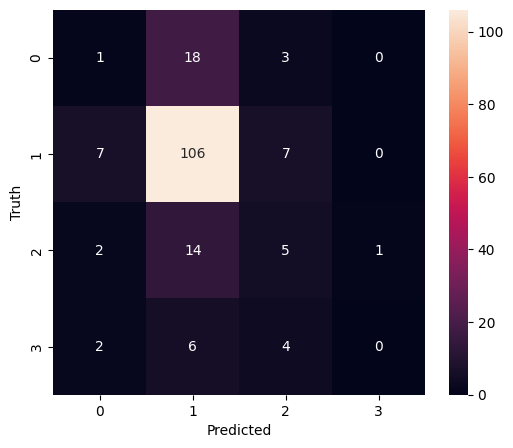

In [26]:
cm = confusion_matrix(y_test, y_predicted)

plt.figure(figsize = (6,5))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')